# **Downloading Data**

https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_eval_partition.csv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
! cp "/content/drive/MyDrive/Colab Notebooks/docs/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/celeba-dataset
! unzip celeba-dataset.zip -d data/

# **Initializing**

In [3]:
PATH = "/content/data"
SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/dumps/celebfaces"

In [4]:
import os
os.listdir(PATH)

['list_eval_partition.csv',
 'list_attr_celeba.csv',
 'list_bbox_celeba.csv',
 'list_landmarks_align_celeba.csv',
 'img_align_celeba']

In [5]:
IMGS_PATH = os.path.join(PATH, "img_align_celeba/img_align_celeba")
ATTR_PATH = os.path.join(PATH, "list_attr_celeba.csv")
EVAL_PATH = os.path.join(PATH, "list_eval_partition.csv")

In [6]:
# Importing Modules
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import sys
import random

# **Loading Data**

In [196]:
N = 24_000  # samples allowed at max
# N = 5_000  # samples allowed at max
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

## Filtering Samples

In [197]:
# Reading Data
df = pd.read_csv(ATTR_PATH)
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [198]:
# COLS = ['Male', 'Smiling', 'Young']
COLS = ['Young', 'Smiling', 'Male']

In [199]:
# Setting image_id as index
df.set_index('image_id', inplace=True)

# Replacing -1 with 0
df.replace(to_replace=-1, value=0, inplace=True)

# Extracting only the selected columns
df = df[COLS]

# Shufflig The DataFrame
df = df.sample(frac = 1)

# Converting datatype to float
df = df.astype("float32")

df.head()

,Young,Smiling,Male
image_id,,,
195948.jpg,1.0,1.0,0.0
031891.jpg,1.0,1.0,1.0
055289.jpg,1.0,0.0,1.0
081159.jpg,1.0,1.0,0.0
045852.jpg,1.0,1.0,1.0


In [200]:
n_from_each_class = min(df.value_counts())
print("Min Available in Each Class:", n_from_each_class)
N_each = N // (2**len(COLS))
if n_from_each_class > N_each:
    n_from_each_class = N_each
n_from_each_class
print("Max Allowed Samples from each class:", N_each)

selected_ids = []
for mode in df.value_counts().index:
    temp_df = df
    for i, m in enumerate(mode):
        temp_df = temp_df[
            temp_df[COLS[i]] == m
        ]
    selected_ids.extend(temp_df.index.values[:n_from_each_class])


# for col in COLS:
#     selected_ids.extend(df[df[col] == 0][:n_from_each_class].index.values)
#     selected_ids.extend(df[df[col] == 1][:n_from_each_class].index.values)

N = len(selected_ids)

print("Total Samples Taken:", N)

Min Available in Each Class: 4687
Max Allowed Samples from each class: 3000
Total Samples Taken: 24000


In [201]:
# Taking only the selected imgages
df = df.loc[selected_ids]

In [202]:
df.value_counts()

Young  Smiling  Male
0.0    0.0      0.0     3000
                1.0     3000
       1.0      0.0     3000
                1.0     3000
1.0    0.0      0.0     3000
                1.0     3000
       1.0      0.0     3000
                1.0     3000
dtype: int64

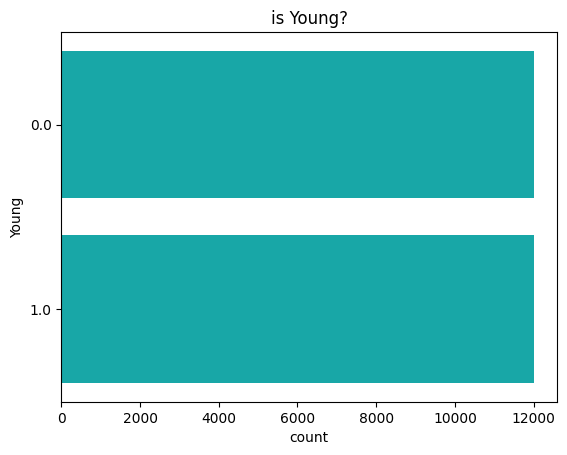

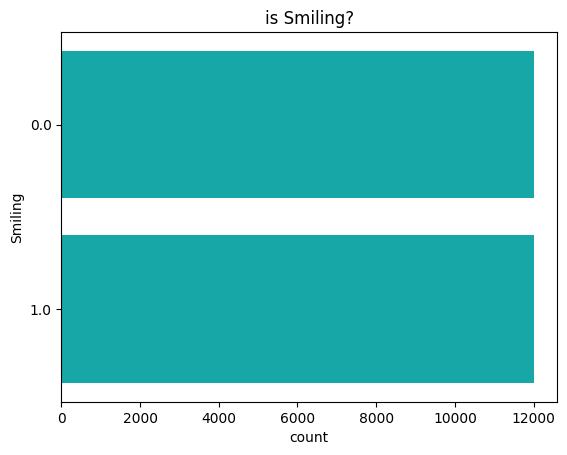

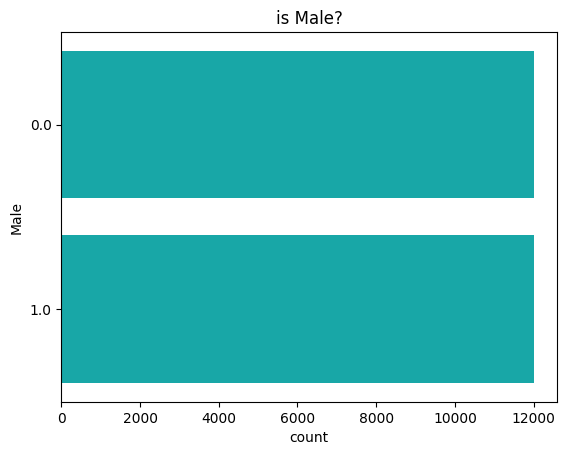

In [203]:
for col in COLS:
    plt.title(f"is {col}?")
    sns.countplot(y=col, data=df, color="c")
    plt.show()

## Splitting

In [204]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(
    test_size = 0.25,
    random_state = 0
)

train_index, test_index = next(sss.split(df.index, df.values))

## Transform

In [205]:
from PIL import Image

def show_img(i, transform=None):
    img_url = os.path.join(IMGS_PATH, df.index[i])

    img = Image.open(img_url).resize(IMG_SIZE)

    if transform:
        img = transform(img).permute(1, 2, 0)
    else:
        img = np.array(img)

    plt.imshow(img)
    plt.show()

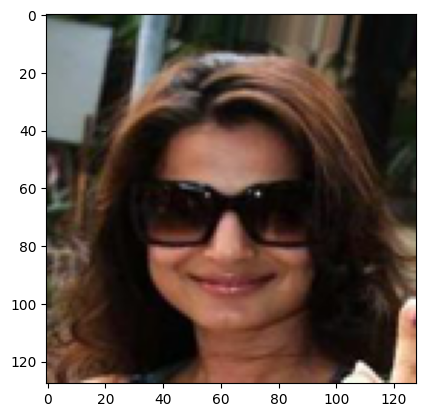

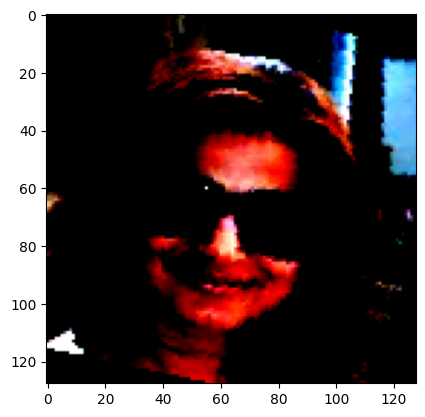

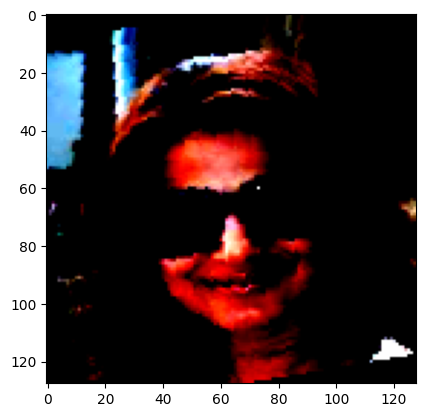

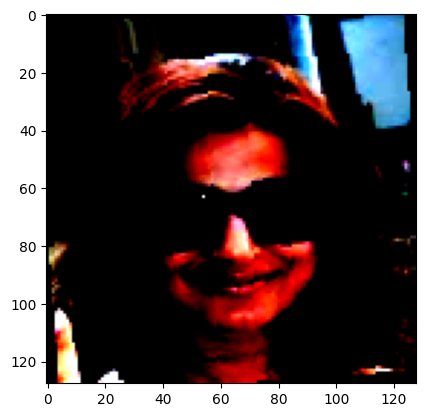

In [206]:
import torchvision

transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    # torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0)),
])

i = 10
show_img(i)
for _ in range(3):
    show_img(i, transform)

## Dataset

In [207]:
class Dataset(torch.utils.data.Dataset):

    # Constructor with defult values 
    def __init__(self, train=True, transform=None):
        if train:
            self.split_index = train_index
        else:
            self.split_index = test_index

        if transform:
            self.transform = transform

        self.len = len(self.split_index)

    def __getitem__(self, index):

        # finding index from shuffled split
        index = self.split_index[index]

        # loading image
        img_name = df.index[index]
        img_url = os.path.join(IMGS_PATH, img_name)
        img = Image.open(img_url).resize(IMG_SIZE)
        if self.transform:
            img = self.transform(img)

        # loading y
        y = df.values[index]

        return img, y
    
    def __len__(self):
        return self.len

In [208]:
train_data = Dataset(
    train = True,
    transform = transform
)
test_data = Dataset(
    train = False,
    transform = transform
)

## Data Loader

In [209]:
# BATCH_SIZE = len(train_data)
# TEST_BATCH_SIZE = len(test_data)
BATCH_SIZE = 64
TEST_BATCH_SIZE = 32

In [210]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data,
    batch_size = TEST_BATCH_SIZE
)

torch.Size([64, 3, 128, 128]) torch.Size([64, 3]) tensor([0., 1., 1.])


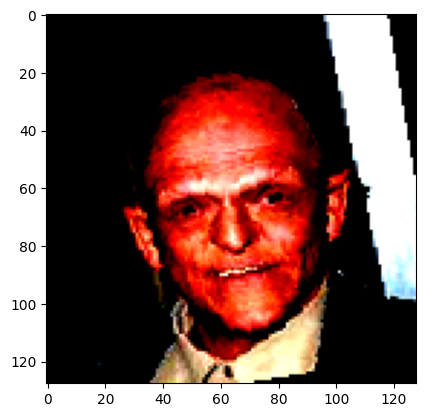

In [211]:
for x, y in train_loader:
    print(x.shape, y.shape, y[0])
    plt.imshow(x[0].permute(1, 2, 0))
    plt.show()
    break

# **Modelling**

In [213]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [214]:
class Model(torch.nn.Module):
    def __init__(self, img_size, output_size):
        super(Model, self).__init__()

        conv_layer_1 = torch.nn.Conv2d(in_channels=3, out_channels=16,  kernel_size=3,  stride=1,  padding=0)
        pool_layer_1 = torch.nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        conv_layer_2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        pool_layer_2 = torch.nn.MaxPool2d(kernel_size=2, stride=1, padding=1)

        hidden_layers = [80]

        self.feature_extraction = torch.nn.Sequential(
            conv_layer_1,
            torch.nn.ReLU(),
            pool_layer_1,
            conv_layer_2,
            torch.nn.ReLU(),
            pool_layer_2,
            torch.nn.Flatten()
        )

        vector_len = self.feature_extraction(
            torch.randn(1, 3, *img_size)
        ).shape[-1]

        hidden_layers = [
            vector_len,
            *hidden_layers,
            output_size,
        ]

        self.deep_network = torch.nn.ModuleList()
        for in_features, out_features in zip(hidden_layers[:-1], hidden_layers[1:]):
            self.deep_network.append(
                torch.nn.Linear(in_features=in_features, out_features=out_features)
            )
    
    def forward(self, x):

        # Applying Feature Extraction
        out = self.feature_extraction(x)

        # Applying Deep Network
        for layer in self.deep_network[:-1]:
            out = layer(out)
            out = torch.relu(out)

        # Final Layer
        out = self.deep_network[-1](out)
        out = torch.sigmoid(out)

        return out

def accuracy(y, y_hat):
    return ((y == y_hat.round()).sum(0) / y.shape[0]).tolist()

model = Model(IMG_SIZE, df.shape[-1]).to(DEVICE)

for k, v in model.state_dict().items():
    print(k, "\tShape:", v.shape)


feature_extraction.0.weight 	Shape: torch.Size([16, 3, 3, 3])
feature_extraction.0.bias 	Shape: torch.Size([16])
feature_extraction.3.weight 	Shape: torch.Size([32, 16, 3, 3])
feature_extraction.3.bias 	Shape: torch.Size([32])
deep_network.0.weight 	Shape: torch.Size([80, 508032])
deep_network.0.bias 	Shape: torch.Size([80])
deep_network.1.weight 	Shape: torch.Size([3, 80])
deep_network.1.bias 	Shape: torch.Size([3])


In [215]:
criterion = torch.nn.BCELoss()
learning_rate = 0.0001
momentum = 0.9
epochs = 10
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from tqdm import tqdm

history = {
    "loss": {"train": [], "test": []},
    "acc": {"train": [], "test": []}
}

for epoch in range(epochs):

    # TRAINING
    batch_loss = []
    batch_acc = []
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()

        y_hat = model(x)
        loss = criterion(y_hat, y.type(torch.float32))
        acc = accuracy(y, y_hat)
        batch_loss.append(loss.item())
        batch_acc.append(acc)
    
        loss.backward()
        optimizer.step()
        # break

        # print("Train Loss:", loss.item())

    batch_loss = np.average(batch_loss)
    batch_acc = np.average(batch_acc, axis=0).round(3)
    history["loss"]["train"].append(batch_loss)
    history["acc"]["train"].append(batch_acc)
    print("Train Acc:", batch_acc, end="\t")
    print("Train Loss:", batch_loss)


    # VALIDATING
    batch_loss = []
    batch_acc = []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            acc = accuracy(y, y_hat)
            batch_loss.append(loss.item())
            batch_acc.append(acc)

            # print("Test Loss:", loss.item())
            # break

    batch_loss = np.average(batch_loss)
    batch_acc = np.average(batch_acc, axis=0).round(3)
    history["loss"]["test"].append(batch_loss)
    history["acc"]["test"].append(batch_acc)
    print("Test Acc:", batch_acc, end="\t")
    print("Test Loss:", batch_loss)

100%|██████████| 282/282 [01:11<00:00,  3.95it/s]


Train Acc: [0.653 0.733 0.787]	Train Loss: 0.5404221805486273
Test Acc: [0.702 0.835 0.869]	Test Loss: 0.42765984208659924


100%|██████████| 282/282 [00:48<00:00,  5.82it/s]


Train Acc: [0.708 0.833 0.873]	Train Loss: 0.4188815013948062
Test Acc: [0.691 0.85  0.899]	Test Loss: 0.39882632915643934


100%|██████████| 282/282 [00:48<00:00,  5.84it/s]


Train Acc: [0.721 0.846 0.899]	Train Loss: 0.38199584946987475
Test Acc: [0.732 0.859 0.909]	Test Loss: 0.3678499476072636


100%|██████████| 282/282 [00:48<00:00,  5.78it/s]


Train Acc: [0.73  0.854 0.909]	Train Loss: 0.3660637915979886
Test Acc: [0.739 0.854 0.918]	Test Loss: 0.36082931393955614


100%|██████████| 282/282 [00:48<00:00,  5.79it/s]


Train Acc: [0.739 0.862 0.916]	Train Loss: 0.35145849433351073
Test Acc: [0.743 0.85  0.919]	Test Loss: 0.3570646542183896


100%|██████████| 282/282 [00:48<00:00,  5.79it/s]


Train Acc: [0.743 0.867 0.923]	Train Loss: 0.34078691973753855
Test Acc: [0.744 0.858 0.924]	Test Loss: 0.34637732621520123


100%|██████████| 282/282 [00:48<00:00,  5.76it/s]


Train Acc: [0.748 0.868 0.925]	Train Loss: 0.3332478606426124
Test Acc: [0.744 0.871 0.921]	Test Loss: 0.33888614011254714


100%|██████████| 282/282 [00:48<00:00,  5.81it/s]


Train Acc: [0.757 0.872 0.93 ]	Train Loss: 0.3238164007346681
Test Acc: [0.74  0.87  0.927]	Test Loss: 0.338367640417307


100%|██████████| 282/282 [00:49<00:00,  5.66it/s]


Train Acc: [0.758 0.875 0.934]	Train Loss: 0.31792669336423807
Test Acc: [0.746 0.879 0.933]	Test Loss: 0.32526359873566224


100%|██████████| 282/282 [00:48<00:00,  5.81it/s]


Train Acc: [0.764 0.875 0.936]	Train Loss: 0.31311195312028234
Test Acc: [0.748 0.875 0.933]	Test Loss: 0.32352254357426724


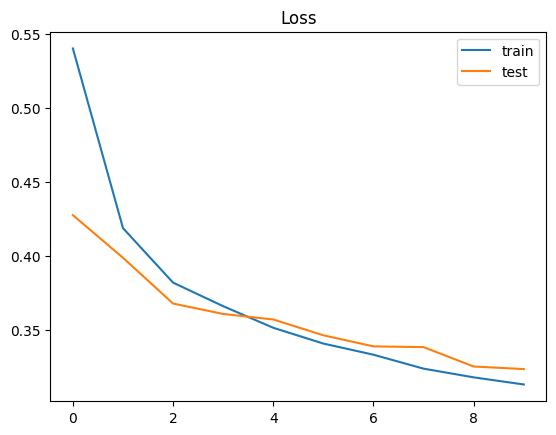

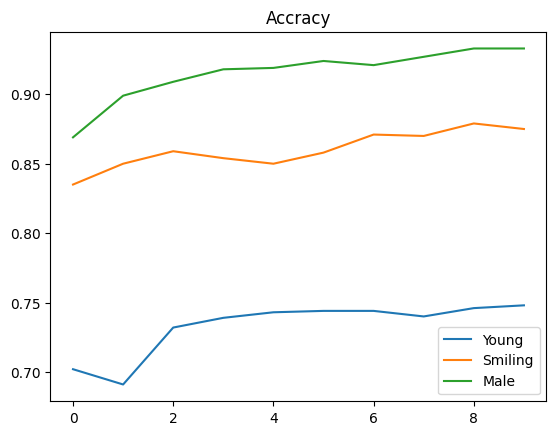

In [216]:
plt.plot(history['loss']['train'], label="train")
plt.plot(history['loss']['test'], label="test")
plt.legend()
plt.title("Loss")
plt.show()

arr = np.array(history['acc']['test'])
for i in range(arr.shape[-1]):
    plt.plot(arr[:, i], label=COLS[i])
plt.legend()
plt.title("Accracy")
plt.show()